In [1]:
import dgl
import numpy as np
import torch.nn as nn
import torch
import math
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output


from collections import namedtuple

Using backend: pytorch


# 0. Requirements
`>> pip install git+https://github.com/openai/multiagent-particle-envs.git`

`>> pip install gym==0.10.5`

# 1. Environment description

There are N agents (blue) and N landmarks (black). Agents are penalized based on how far any agent is from each landmark. Agents are penalized if they collide with other agents. So, agents have to learn to cover all the landmarks while avoiding collisions.

## 1.1 State
Each agent's state is n-dimensional state, with following components:


<center>[agent.state.p_vel] + [agent.state.p_pos] + entity_pos + other_pos + comm</center>

    
- `agent.state.p_vel` : x, y speed (2-dim)
- `agent.state.p_pos` : x, y position (2-dim)
- `entity_pos` : x, y position of landmarks (2 * N dim)
- `other_pos`: x, y poisition of other agents (2 * (N-1) dim)

## 1.2 Action

Agent's action is 5-dimensional, where each element implies the velocity of the direction:

<center>[hold, right, left, up, down]</center>

For example, if action is [0, 1, 0, 0, 1], the agent is moving to the north-east direction with speed $\sqrt{2}/\text{timestep}$ .

**NOTE**: In this project, we will only use one-hot action to discritize the action space.

## 1.3 Reward

Modified version of the original simple-spread environment (see `simple_spread.py` file)

In [46]:
from simple_spread import Scenario

def make_env():
    from multiagent.environment import MultiAgentEnv

    # load scenario from script
    scenario = Scenario()
    
    # create world
    world = scenario.make_world()
    
    # create multiagent environment
    env = MultiAgentEnv(world, scenario.reset_world, scenario.reward, scenario.observation)
    env.shared_reward = False
    
    return env

env = make_env()

## Plotting the state of the environment

As the `env.render()` option causes some error on the jupyter notebook, you can use a customized plotting function to visualize.

In [49]:
def vis_state(env):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    
    # msking rectangle
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_xticks([])
    ax.set_yticks([])
    
    # plotting agent and landmarks
    for entity in env.world.entities:
        color = entity.color
        size = entity.size
        center = entity.state.p_pos
        draw_circle = plt.Circle(center, size, color=color)
        ax.add_artist(draw_circle)
    plt.show()
    clear_output(wait=0.1)

Using above `vis_state` function, you can plot the dynamic of the environment

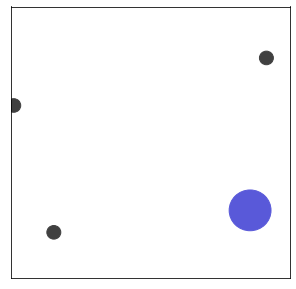

In [50]:
n_episodes = 1
max_timestep = 30
n_agents = env.n
action_dim = env.action_space[0].n
random_prob = [1 / action_dim for _ in range(action_dim)] # each agent are using random policy

for e in range(n_episodes):
    t = 0
    env.reset() # Reset everything to make clean start.
    terminated = False    
    state = env.reset() # give you a list that contains each agent's observaion

    while True:             
        vis_state(env)
        t += 1
        action = [np.random.multinomial(1, random_prob) for _ in range(n_agents)]
        next_state, reward, terminated, _ = env.step(action)
        
        if all(terminated) or t >= max_timestep:            
            break

## __NOTE__
The action should be list of length N (=#.agents), where element $i$ is the one-hot action (type:`numpy.array`) for the agent $i$.


In [30]:
rand_action

[array([0, 1, 0, 0, 0]), array([0, 1, 0, 0, 0]), array([1, 0, 0, 0, 0])]

# 2. Neural Networks
## 2.1. Multi-Layered-Perceptron

In [31]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dims=[32], hidden_act=nn.LeakyReLU(), out_act=nn.LeakyReLU()):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()
        
        in_dims = [in_dim] + hidden_dims
        out_dims = hidden_dims + [out_dim]
        
        for _in, _out in zip(in_dims, out_dims):
            self.layers.append(nn.Linear(_in, _out))
        
        for i in range(len(hidden_dims)):
            self.activations.append(hidden_act)
        self.activations.append(out_act)
        
    def forward(self, x):
        for l, a in zip(self.layers, self.activations):
            x = l(x)
            x = a(x)
            
        return x       

## 2.2. Multi-Head-Attention Layer
https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf

The attention layer learns an weights of the incoming edges. For a node $i$ with hidden embedding $h_i$, the score of node $j$ with along the incoming edge $(i,j)$ is calculated as follows:

\begin{equation*}
k_i = W_K \cdot h_i \\
q_j = W_Q \cdot h_j\\
v_i = W_V \cdot h_i \\
{score}_{ij} = q_j^T k_i
\end{equation*}

where $W_q,W_k,W_v$ map the representations $h$ to “query”, “key”, and “value” space respectively. The dot product measures the similarity of a given query $q_j$ and a key $k_i$.

The score is then used to compute the sum of the incoming values, normalized over the weights of edges.

\begin{equation*}
w_{ji}={exp(score_{ji}) \over \sum_{k\in Nb(i)}exp(score_{ki})} \\
\end{equation*}

For each node, the value of all incoming nodes are weighted and summed together, say $wv_i$. Finally, we apply final output weight $W_o$ to produce the output.

\begin{equation}
wv_i = \sum_{j\in Nb(i)} w_{ji} v_j \\
h_i' = W_o \cdot wv_i
\end{equation}

In Transformer, attention is multi-headed. The multi-head attention consists of multiple attention heads, in which each head refers to a single attention module. $wv_i$ for all the heads are concatenated and mapped to output o
 with an affine layer:

\begin{equation}
h_i'=W_o\cdot concat([wv_i^1, wv_i^2, \dots,wv_i^K])
\end{equation}

where K is the number of the heads.

<div>
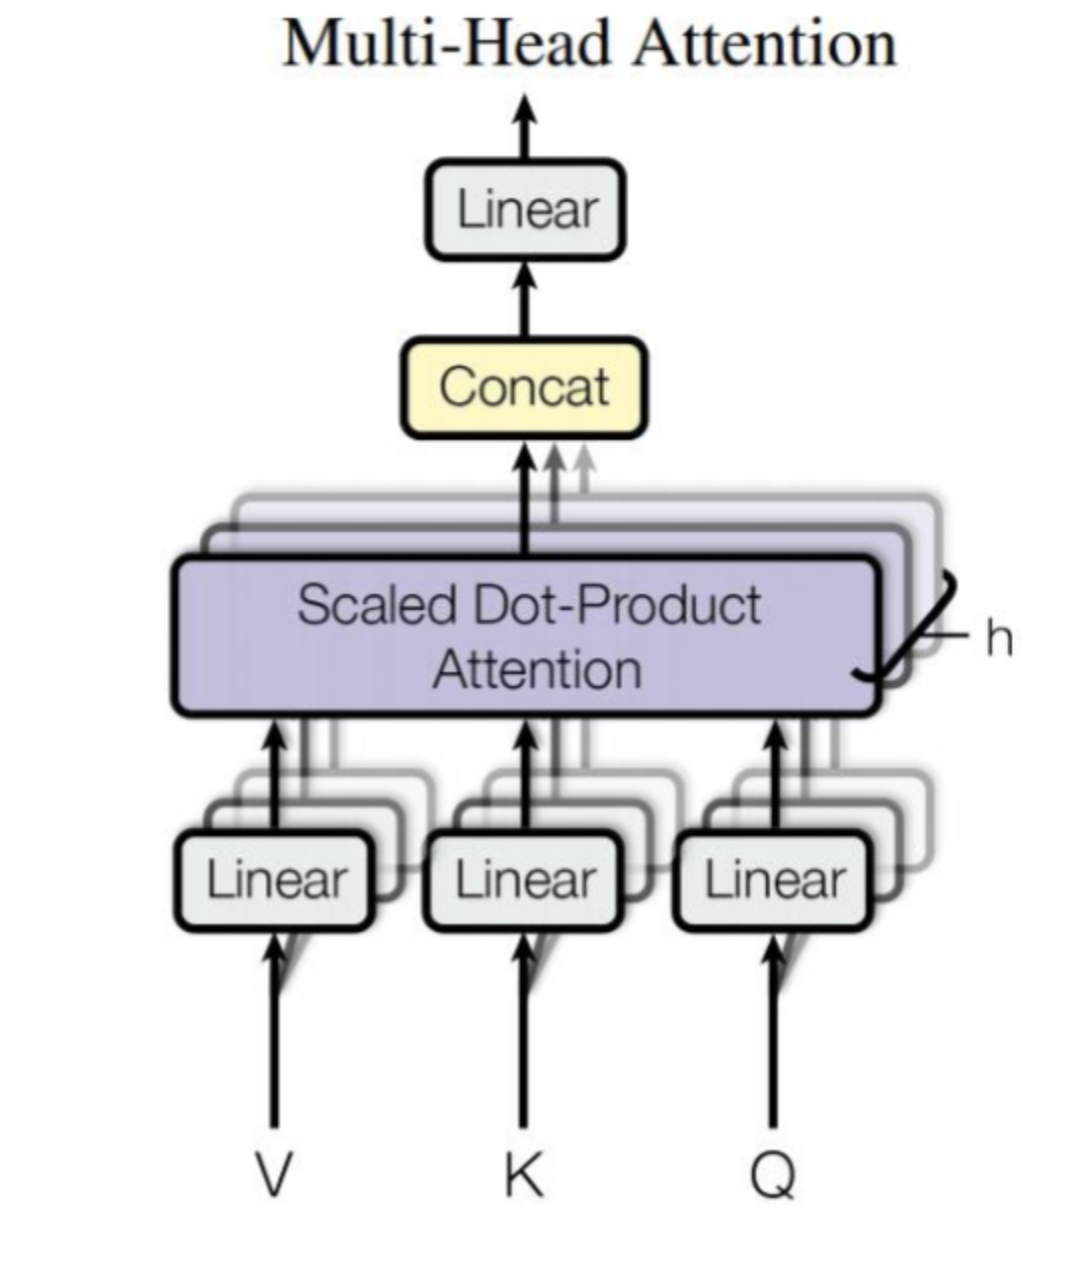
</div>

source: https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf



In [133]:
class MultiHeadAttnLayer(nn.Module):
    def __init__(self, model_dim, num_heads=2, merge='cat'):
        super(MultiHeadAttnLayer, self).__init__()

        self.K = nn.ModuleList()
        self.Q = nn.ModuleList()
        self.V = nn.ModuleList()
        
        self.num_heads = num_heads
        self.merge = merge

        for i in range(num_heads):
            self.K.append(nn.Linear(model_dim, model_dim))
            self.Q.append(nn.Linear(model_dim, model_dim))
            self.V.append(nn.Linear(model_dim, model_dim))

        if merge == 'cat':
            self.O = nn.Linear(model_dim * num_heads, model_dim)
        else:
            # merge using 'mean'
            self.O = nn.Linear(model_dim, model_dim)


    def forward(self, graph, node_feature):
        graph.ndata['nf'] = node_feature
        graph.update_all(self.message_func, self.reduce_func, self.apply_nodes)

        out_nf = graph.ndata.pop('out_nf')
        _ = graph.ndata.pop('nf')
        weight = graph.ndata.pop('weight')

        return out_nf, weight

    def message_func(self, edges):
        # (i,j)
        src_nf = edges.src['nf'] # h_i, shape = [batch , model_dim]
        dst_nf = edges.dst['nf'] # h_j, shape = [batch , model_dim]

        ret_dict = dict()

        for h in range(self.num_heads):
            # computing score
            k = self.K[h](src_nf)  # shape = [batch , model_dim]
            q = self.Q[h](dst_nf)  # shape = [batch , model_dim]
            score = (k * q).sum(-1) # summation over model dimension
            score = score.reshape(-1, 1) # shape = [batch , 1]
            ret_dict['score_{}'.format(h)] = score
            
            # computing value
            ret_dict['value_{}'.format(h)] = self.V[h](src_nf) # shape = [batch, model_dim]

        return ret_dict

    def reduce_func(self, nodes):

        ret_dict = dict()

        for h in range(self.num_heads):
            value = nodes.mailbox['value_{}'.format(h)]  # shape = [batch , num_edges , model_dim]
            score = nodes.mailbox['score_{}'.format(h)]  # shape = [batch , num_edges , 1]
            
            weight = torch.softmax(score, dim=1)  # shape = [batch , num_edges , 1]

            weighted_value_sum = (weight * value).sum(1)  # summation over edge dimension
            ret_dict['wv_{}'.format(h)] = weighted_value_sum
            
            ret_dict['w_{}'.format(h)] = weight.squeeze()

        return ret_dict

    def apply_nodes(self, nodes):
        o_input = []
        weights = []
        for h in range(self.num_heads):
            o_input.append(nodes.data['wv_{}'.format(h)])  # shape = [# nodes , model_dim]
            weights.append(nodes.data['w_{}'.format(h)])

        if self.merge == 'cat':
            o_input = torch.cat(o_input, dim=-1)
        else:
            o_input = torch.stack(o_input)  # shape = [# heads , # nodes , model_dim]
            o_input = o_input.mean(0)  # mean over attn head dimension
            
        weights = torch.stack(weights)
        weights = weights.mean(0)

        o = self.O(o_input)
        return {'out_nf': o, 'weight':weights}

# Applying attention layer to a random graph

In [134]:
feature_dim = 3
num_nodes = 5

def get_fully_connected_edges(num_agents, self_edge=True):
    from_idx = []
    to_idx = []
    for i in range(num_agents):
        for j in range(num_agents):
            if self_edge:
                from_idx.append(i)
                to_idx.append(j)
            else:
                if i!=j:
                    from_idx.append(i)
                    to_idx.append(j)
    return from_idx, to_idx

edge_from, edge_to = get_fully_connected_edges(num_nodes)

ex_graph = dgl.DGLGraph()
ex_graph.add_nodes(num_nodes)
ex_graph.add_edges(edge_from, edge_to)


In [135]:
# generate a random node feature
node_feature = torch.randn(num_nodes, feature_dim)

# testing MultiHeadattn
attn = MultiHeadAttnLayer(feature_dim)
attn(ex_graph, node_feature)

(tensor([[ 0.3308, -0.1578, -0.3344],
         [ 0.5486,  0.0929, -0.1014],
         [ 0.5039,  0.0346, -0.1532],
         [ 0.2787, -0.2068, -0.3882],
         [ 0.6120,  0.1618, -0.0312]], grad_fn=<AddmmBackward>),
 tensor([[0.1586, 0.3786, 0.1946, 0.1439, 0.1243],
         [0.2140, 0.2200, 0.2188, 0.1708, 0.1763],
         [0.1983, 0.2537, 0.2080, 0.1824, 0.1576],
         [0.1499, 0.4222, 0.1902, 0.1275, 0.1102],
         [0.2237, 0.1911, 0.1776, 0.2516, 0.1561]], grad_fn=<MeanBackward1>))

## 2.3. Gnerate Mtattn Model


In [136]:
class RelationalGNN(nn.Module):
    def __init__(self, init_dim, hidden_dim, num_layers=1, num_heads=2, merge='cat'):
        super(RelationalGNN, self).__init__()
        
        self.encoder = MLP(init_dim, hidden_dim) # first encode the node feature to hidden_dim
        self.attn = nn.ModuleList()
        
        for i in range(num_layers):
            self.attn.append(MultiHeadAttnLayer(hidden_dim, num_heads, merge))
            
    def forward(self, graph, node_feature):
        node_feature = self.encoder(node_feature)
        
        for attn_layer in self.attn:
            node_feature, weight = attn_layer(graph, node_feature)
            
        return node_feature, weight       

In [137]:
# testing GNN
GNN = RelationalGNN(init_dim = feature_dim, hidden_dim=32)
GNN(ex_graph, node_feature)

(tensor([[ 0.0038,  0.0374,  0.1996,  0.0119, -0.1307,  0.0840, -0.1575,  0.1443,
          -0.1543, -0.0747,  0.0223, -0.0825, -0.0443,  0.0851, -0.1803, -0.0939,
          -0.0912, -0.0080, -0.0782, -0.1606, -0.0251,  0.0672, -0.0188,  0.0152,
           0.0671,  0.0921, -0.0298, -0.0121, -0.0592, -0.0151, -0.0025,  0.1031],
         [ 0.0017,  0.0376,  0.1998,  0.0116, -0.1325,  0.0836, -0.1574,  0.1450,
          -0.1571, -0.0764,  0.0233, -0.0828, -0.0455,  0.0853, -0.1817, -0.0951,
          -0.0917, -0.0073, -0.0789, -0.1618, -0.0242,  0.0663, -0.0207,  0.0140,
           0.0664,  0.0922, -0.0302, -0.0117, -0.0593, -0.0152, -0.0011,  0.1033],
         [ 0.0043,  0.0372,  0.1999,  0.0118, -0.1306,  0.0842, -0.1575,  0.1444,
          -0.1544, -0.0751,  0.0218, -0.0824, -0.0447,  0.0852, -0.1801, -0.0942,
          -0.0912, -0.0082, -0.0778, -0.1607, -0.0248,  0.0674, -0.0188,  0.0149,
           0.0671,  0.0920, -0.0299, -0.0122, -0.0588, -0.0148, -0.0028,  0.1034],
         [ 0.

# 3. Agent
## 3.1. Replay Memory

In [138]:
Transition = namedtuple('Transition', ('graph', 'action', 'reward', 'next_graph', 'done'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Save Transitions"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        samples = random.sample(self.memory, batch_size)
        
        graphs = [sample[0] for sample in samples]
        actions = [sample[1] for sample in samples]
        rewards = [sample[2] for sample in samples]
        next_graphs = [sample[3] for sample in samples]
        dones = [sample[4] for sample in samples]
        
        ret_graph = dgl.batch(graphs)
        ret_action = torch.stack(actions).reshape(-1, 1)
        ret_reward = torch.Tensor(rewards).reshape(-1)
        ret_next_graph = dgl.batch(next_graphs)
        ret_dones = torch.Tensor(dones).reshape(-1)

        
        return ret_graph, ret_action, ret_reward, ret_next_graph, ret_dones

    def __len__(self):
        return len(self.memory)

## Agent architecture

Agent network has following functions:

* `get_action` : produces an action using graph, with an exploration
* `get_qs` : produces Q-value for every agent.
* `get_target_qs` : produces target Q-value for every agent.
* `save_samples` : saves a transition to the memory. 
* `fit`
* `convert_to_onehot_action` : converts an integer action to the onehot action. 

    **input**: integer action.  ex)      
          [2, 1, 3]
    
    **output**: one-hot action.      ex)   
          [[0, 0, 1, 0],
           [0, 1, 0, 0],
           [0, 0, 0, 1]]
    
Agent also saves some hyperparameter for traing;

- `hidden_dim`
    - hidden size for Q-network and MHATTN model
- `gamma`
    - discounting $\gamma$.
- `memory_size`
    - memory size of `Replaybuffer`
- `batch_size`
- `epsilon_start`
- `epsilon_decay` 
    - amount of epsilon decaying per step
- `epsilon_min`



In [140]:
class Agent(nn.Module):
    def __init__(self, n_agents, state_dim, n_actions, hidden_dim=20, gamma=0.9, memory_size=5000, batch_size=20,
                epsilon_start = 0.99, epsilon_decay = 0.9999, epsilon_min= 0.01, update_target=50):
        super(Agent, self).__init__()
        self.GNN = RelationalGNN(state_dim, hidden_dim) 
        self.Qnet = MLP(hidden_dim, n_actions, out_act=nn.Identity()) # Q-network
        self.target_Qnet = MLP(hidden_dim, n_actions, out_act=nn.Identity()) #target Q-network

        # Initialize target Qnet
        self.target_Qnet.load_state_dict(self.Qnet.state_dict())
        
        # the Q network and GNN are trained with end-to-end framework
        self.optimizer = torch.optim.Adam(list(self.GNN.parameters()) + list(self.Qnet.parameters()), lr=1e-4)
        self.loss_ftn = nn.MSELoss()

        self.gamma = gamma
        
        # epsilon for exploration
        self.epsilon = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.memory = ReplayMemory(memory_size)
        self.batch_size = batch_size

        self.num_fit = 0
        self.update_target = update_target # update target network every {X} fits

        self.n_agents = n_agents
        self.n_actions = n_actions

    def get_action(self, graph):
        rand_num = random.random()

        # exploration
        if rand_num < self.epsilon:
            action = torch.randint(low=0, high=self.n_actions, size=(self.n_agents,))

        else:
            # exploitation
            qs = self.get_qs(graph)
            action = qs.argmax(dim=-1).detach()

        # decaying epsilon
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        # convert integer action to environment action
        env_action = self.convert_to_onehot_action(action)

        return action, env_action

    def get_qs(self, graph):
        observation = graph.ndata['obs']
        node_feature, weight = self.GNN(graph, observation)
        qs = self.Qnet(node_feature)

        return qs

    def get_target_qs(self, graph):
        observation = graph.ndata['obs']
        node_feature, weight = self.GNN(graph, observation)
        qs = self.target_Qnet(node_feature)
        return qs

    def save_samples(self, g, a, r, n_g, t):
        self.memory.push(g, a, r, n_g, t)

    def fit(self):
        
        if len(self.memory) < self.batch_size * 10:
            return False, 0

        graph, action, reward, next_graph, done = self.memory.sample(self.batch_size)

        curr_qs = self.get_qs(graph)
        selected_qs = curr_qs.gather(1, action).reshape(-1)

        next_qs = self.get_target_qs(next_graph)  # shape = [n_ag * n_batch, n_action]
        next_max_qs, _ = next_qs.max(dim=1)
        target = reward + self.gamma * next_max_qs * (1 - done)
        target = target.detach()

        loss = self.loss_ftn(selected_qs, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.num_fit % self.update_target == 0:
            self.target_Qnet.load_state_dict(self.Qnet.state_dict())

        self.num_fit += 1

        return True, loss.item()

    def convert_to_onehot_action(self, actions):
        onehot_action = [[0 for _ in range(self.n_actions)] for _ in range(self.n_agents)]
        for i in range(self.n_agents):
            selected_action = actions[i] 
            onehot_action[i][selected_action] = 1
        return onehot_action

# 4. Converting observation to graph

* `get_fully_connected_edges`: produces an fully connected edge, given number of agents
* `generate_graph_with_obs`: generates a dgl graph, where each node has agent's observation as a node feature.

In [141]:
def get_fully_connected_edges(num_agents, self_edge=True):
    from_idx = []
    to_idx = []
    for i in range(num_agents):
        for j in range(num_agents):
            if self_edge:
                from_idx.append(i)
                to_idx.append(j)
            else:
                if i!=j:
                    from_idx.append(i)
                    to_idx.append(j)
    return from_idx, to_idx

def generate_graph_with_obs(obs):
    g = dgl.DGLGraph()
    n_agents = len(obs)
    g.add_nodes(n_agents)
    
    from_idx, to_idx = get_fully_connected_edges(n_agents, self_edge=True)
    g.add_edges(from_idx, to_idx)
    
    # we save observation as the feature of the nodes
    g.ndata['obs'] = torch.Tensor(obs) # shape = (n_agents x state_dim)

    return g

## Full training code

In [142]:
env = make_env()

n_episodes = 500 # in the homework, please use more than 1000 episodes

n_agents = env.n
state_dim = env.observation_space[0].shape[0]
n_actions = env.action_space[0].n # we assume all homogeneous agents

# agent hyperparameters
hidden_dim=20
gamma=0.9
memory_size=1000
batch_size=20
epsilon_start = 0.99
epsilon_decay = 0.9999
epsilon_min= 0.01
update_target = 50


agent = Agent(n_agents, state_dim, n_actions, 
              hidden_dim=hidden_dim,
              gamma=gamma, 
              memory_size=memory_size,
              epsilon_start=epsilon_start,
              epsilon_decay=epsilon_decay,
              epsilon_min=epsilon_min,
              update_target=update_target
             )

# environmnt parameter
max_timestep = 15

# logging 
ep_reward_traj = []
loss_traj = []
epsilon_traj = []
for e in range(n_episodes):
    t = 0
    env.reset() # Reset everything to make clean start.
    terminated = False
    episode_reward = 0
    
    state = env.reset() # give you a list that contains each agent's observaion
    graph = generate_graph_with_obs(state)

    while True:             
        t += 1
        action, env_action = agent.get_action(graph)
        
        next_state, reward, terminated, _ = env.step(env_action)
        next_graph = generate_graph_with_obs(next_state)
        
        normlized_reward = [r  for r in reward]
        

        agent.save_samples(graph, action, normlized_reward, next_graph, terminated)
        
        trained, loss = agent.fit()
        
        if trained:
            loss_traj.append(loss)
            
        episode_reward += sum(normlized_reward)
        
        if all(terminated) or t >= max_timestep:
            ep_reward_traj.append(episode_reward)
            epsilon_traj.append(agent.epsilon)
            
            print("EP:{}, SUM_RWD:{:5.2f}, epsilon:{:5.2f}, loss:{:5.2f}".format(e, episode_reward, agent.epsilon, loss))
            
            break
            

env.close()

plt.plot(loss_traj)
plt.title('loss')
plt.show()

plt.plot(ep_reward_traj)
plt.title('reward')
plt.show()

plt.plot(epsilon_traj)
plt.title('epsilon')
plt.show()

EP:0, SUM_RWD:-34.67, epsilon: 0.99, loss: 0.00
EP:1, SUM_RWD:-23.85, epsilon: 0.99, loss: 0.00
EP:2, SUM_RWD:-47.99, epsilon: 0.99, loss: 0.00
EP:3, SUM_RWD:-25.29, epsilon: 0.98, loss: 0.00
EP:4, SUM_RWD:-19.62, epsilon: 0.98, loss: 0.00
EP:5, SUM_RWD:-6.74, epsilon: 0.98, loss: 0.00
EP:6, SUM_RWD:-32.01, epsilon: 0.98, loss: 0.00
EP:7, SUM_RWD:-40.32, epsilon: 0.98, loss: 0.00
EP:8, SUM_RWD:-14.43, epsilon: 0.98, loss: 0.00
EP:9, SUM_RWD:-43.09, epsilon: 0.98, loss: 0.00
EP:10, SUM_RWD:-39.09, epsilon: 0.97, loss: 0.00
EP:11, SUM_RWD:-1.06, epsilon: 0.97, loss: 0.00
EP:12, SUM_RWD:-25.41, epsilon: 0.97, loss: 0.00
EP:13, SUM_RWD:-41.52, epsilon: 0.97, loss: 0.67
EP:14, SUM_RWD:-37.68, epsilon: 0.97, loss: 0.50
EP:15, SUM_RWD:-21.82, epsilon: 0.97, loss: 0.51
EP:16, SUM_RWD:-53.87, epsilon: 0.97, loss: 0.54
EP:17, SUM_RWD:-43.99, epsilon: 0.96, loss: 0.71
EP:18, SUM_RWD:-34.42, epsilon: 0.96, loss: 0.69
EP:19, SUM_RWD:-19.91, epsilon: 0.96, loss: 0.61
EP:20, SUM_RWD:-36.84, epsilon: 

KeyboardInterrupt: 

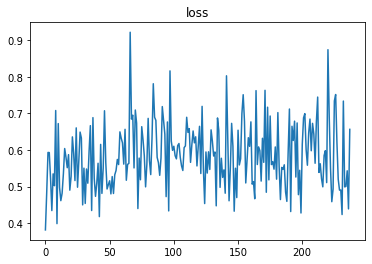

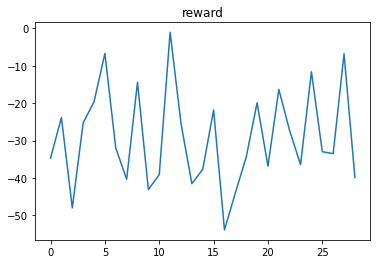

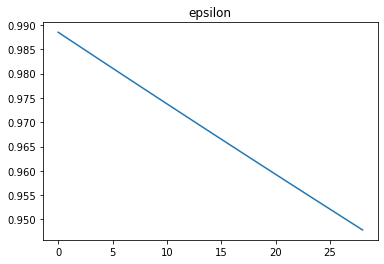

In [143]:

plt.plot(loss_traj)
plt.title('loss')
plt.show()

plt.plot(ep_reward_traj)

plt.title('reward')
plt.show()

plt.plot(epsilon_traj)
plt.title('epsilon')
plt.show()

# Testing Trained agents

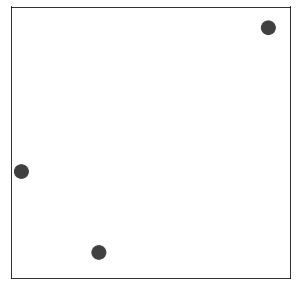

In [144]:
n_episodes = 1 
max_timestep = 100
agent.epsilon = 0

for e in range(n_episodes):
    t = 0
    env.reset() # Reset everything to make clean start.
    terminated = False    
    state = env.reset() # give you a list that contains each agent's observaion
    graph = generate_graph_with_obs(state)

    while True:             
        vis_state(env)
        t += 1
        action, env_action = agent.get_action(graph)
        
        next_state, reward, terminated, _ = env.step(env_action)
        next_graph = generate_graph_with_obs(next_state)
                
        if all(terminated) or t >= max_timestep:
            
            break

# Homework

In this tutorial, I implemented some part of the DGN (chapter 3.1 and 3.2). The loss function to train agent's Q-value in this tutorial was 

\begin{equation}
\mathcal{L}(\theta) = {1\over S} \sum_s {1 \over N} \sum_{i=1}^N (y_i-Q(o_i,a_i;\theta))^2
\end{equation}

In the original paper, the authors introduce the regulazation term in the loss function. 

\begin{equation}
\mathcal{L}(\theta) = {1\over S} \sum_s {1 \over N} \sum_{i=1}^N (y_i-Q(o_i,a_i;\theta))^2 + \lambda D_{KL}(\mathcal{G}(o_i, \theta)||z_i)
\end{equation}

The regulization term encourages agent to form consistemt cooperation between the timestep. Please implement above `consistent regulization` term and compare the performence between DGN-R (remove temporal regulization, upper) and DGN (lower).

**Note**: you just can apply to the last layer of the attention layer for the KL divergence

In [145]:
# hint code
state = graph.ndata['obs']
curr_nf, curr_weight = agent.GNN(graph, state)

next_state = next_graph.ndata['obs']
next_nf, next_weight = agent.GNN(next_graph, next_state)

In [146]:
curr_weight

tensor([[0.3029, 0.3836, 0.3135],
        [0.2970, 0.4035, 0.2995],
        [0.2994, 0.3900, 0.3106]], grad_fn=<MeanBackward1>)

In [147]:
next_weight

tensor([[0.2262, 0.5448, 0.2289],
        [0.2280, 0.5404, 0.2316],
        [0.2255, 0.5454, 0.2291]], grad_fn=<MeanBackward1>)

## KL divergence

\begin{equation}
KL(p||q)= H(p,q) - H(p)\\
=\sum_i p_i \cdot log({p_i \over q_i})
\end{equation}

so, the kl divergence between the previous weight and next weight can be calculated as:

In [150]:
KL = (next_weight * torch.log(next_weight/curr_weight)).sum(-1)

In [151]:
KL

tensor([0.0532, 0.0380, 0.0493], grad_fn=<SumBackward1>)